In [3]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [4]:
sns.set_palette('Set2')
%matplotlib inline

# Get data

#### The data of Bitcoin/USD, we use joint URL in order to analyze the effect Ethereum later.

In [17]:
# API of Cryptographic currency in json format
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=USD&limit=2000')
# AUD train model时，会出现loss = NAN的情况。但是不知道为什么
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-05-17,123.50,125.56,116.57,118.21,79123.93,9608029.60
2013-05-18,123.21,125.31,122.25,123.50,22652.03,2804847.39
2013-05-19,122.50,124.50,119.50,123.21,20571.91,2507881.36
2013-05-20,122.02,123.69,120.10,122.50,17316.21,2118341.03
2013-05-21,122.89,123.08,121.10,122.02,13386.53,1637410.81


In [504]:
hist.describe()

,close,high,low,open,volumefrom,volumeto
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03
mean,2267.651699,2341.140505,2176.725112,2264.455552,61551.997286,2.218537e+08
std,3424.768387,3557.339130,3255.410394,3423.802713,56127.538954,4.937617e+08
min,68.500000,75.000000,65.420000,68.500000,404.380000,2.101127e+05
25%,321.120000,332.010000,309.480000,320.020000,22876.300000,8.409629e+06
50%,594.960000,604.870000,584.820000,593.140000,48026.760000,2.199148e+07
75%,2545.430000,2617.480000,2472.370000,2541.620000,83028.450000,2.103188e+08
max,19345.490000,19870.620000,18750.910000,19346.600000,517733.910000,6.245732e+09


#### Now set close price as target data, and later we will add price gap into model

In [18]:
target_col = 'close'

# Split training and test dataset

80% is used for training, 20% is used for testing.

In [19]:
# def train_test_split(df, test_size=0.5):
#     split_row = len(df) - int(test_size * len(df))
#     train_data = df.iloc[:split_row]
#     test_data = df.iloc[split_row:]
#     return train_data, test_data

set train dataset and test dataset by specific date

In [468]:
from datetime import datetime,timedelta
import pandas as pd
date = datetime(year=2018, month=9, day=14)
date_train_begin = date - timedelta(days=270)
date_train_end = date
date_test_begin = date-timedelta(days=7)
date_test_end = date+timedelta(days=6)
train_data = hist.loc[date_train_begin:date_train_end]
test_data = hist.loc[date_test_begin:date_test_end]

In [469]:
date_train_begin

datetime.datetime(2017, 12, 18, 0, 0)

In [470]:
print("traindata shape"+str(train_data.shape)+'\n'+'testdata shape'+str(test_data.shape))

traindata shape(271, 6)
testdata shape(14, 6)


# Build LSTM Model

#### Normalization

As the model does not ought to predict future price, but future change percentage.

In [471]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

#### smoothed data for average-7-days

In [472]:
def extract_window_data(df, window_len, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
#         print('window_data shape'+len(window_data.shape))
    return np.array(window_data)

In [473]:
def prepare_data(df, target_col, window_len, zero_base=True, test_size):
    """ Prepare data for LSTM. """
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

#### 1 layer LSTM model

In [474]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    print('input_data.shape'+str(input_data.shape))
    # input shape = (window length,window length - 1)
    # input shape tutorial: https://yq.aliyun.com/articles/194956
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [475]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [476]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [477]:
# 264 是样本个数
# 6是因为原来的dataframe有6列,6是特征个数
# 3D：LSTM input
X_train.shape

(264, 7, 6)

In [478]:
X_test.shape

(7, 7, 6)

In [479]:
from keras.callbacks import EarlyStopping

# patience=2: 两次loss连续上升就会停止
early_stopping = EarlyStopping(monitor='loss', patience=2)

model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
# 即使加入更多的维度/比如4个价格，只要确定了y_train,得到预测的变化值后，乘回来就可以了
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=1, shuffle=True,callbacks=[early_stopping])

input_data.shape(264, 7, 6)
Epoch 1/50
264/264 [==============================] - 4s 13ms/step - loss: 0.1041
Epoch 2/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0774
Epoch 3/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0620
Epoch 4/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0601
Epoch 5/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0585
Epoch 6/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0542
Epoch 7/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0550
Epoch 8/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0517
Epoch 9/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0506
Epoch 10/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0476
Epoch 11/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0469
Epoch 12/50
264/264 [==============================] - 1s 3ms/step - loss: 0.0

In [501]:
# input_shape: 3D tensor with shape (batch_size, timesteps, input_dim)
# 但很明显，这并不是
X_train.shape

(264, 7, 6)

# Prediction

In [480]:
preds = model.predict(X_test)
preds

array([[ 0.0072877 ],
       [ 0.04797451],
       [ 0.04911656],
       [ 0.04202272],
       [ 0.01559135],
       [ 0.00431414],
       [-0.01848166]], dtype=float32)

In [481]:
preds = model.predict(X_test).squeeze()
preds

array([ 0.0072877 ,  0.04797451,  0.04911656,  0.04202272,  0.01559135,
        0.00431414, -0.01848166], dtype=float32)

In [482]:
targets = test[target_col][window_len:]
targets.shape

(7,)

In [483]:
# 由第0天乘以训练出来的预测率，预测第7天
preds = test[target_col].values[:-window_len] * (preds + 1)
preds.shape

(7,)

In [484]:
# targets是由test进行乘法计算得到的，所以依然保持了test的index
targets

time
2018-09-14    6486.01
2018-09-15    6522.08
2018-09-16    6502.44
2018-09-17    6261.48
2018-09-18    6346.44
2018-09-19    6398.80
2018-09-20    6505.90
Name: close, dtype: float64

In [485]:
preds

array([6458.50739011, 6497.60937304, 6556.00314331, 6590.19965668,
       6393.69617521, 6364.44945976, 6372.01698661])

In [486]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [AUD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

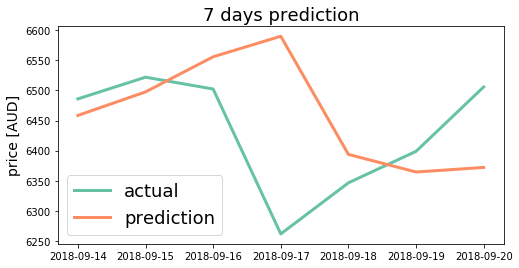

In [487]:
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds,'actual', 'prediction','7 days prediction', lw=3)

In [488]:
import math
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(targets, preds)
rmse = math.sqrt(mse)
print(rmse)

138.16066999070807


In [489]:
file = pd.concat([targets, preds],axis=1)
file.columns = ['targets', 'preds']
file['rmse'] = rmse
file

,targets,preds,rmse
time,,,
2018-09-14,6486.01,6458.507390,138.16067
2018-09-15,6522.08,6497.609373,138.16067
2018-09-16,6502.44,6556.003143,138.16067
2018-09-17,6261.48,6590.199657,138.16067
2018-09-18,6346.44,6393.696175,138.16067
2018-09-19,6398.80,6364.449460,138.16067
2018-09-20,6505.90,6372.016987,138.16067


### 以上，模型用了window_len进行平移，也就是说，其实还是用了真实的值，预测下一天的值。比如第7天的值，是用前7天的test值进行预测的，所以严格意义上来说，这个模型太简单

In [1]:
int(8.5)

8

In [2]:
int(8.6)

8

In [6]:
from pandas import DataFrame
import pandas as pd
d1 = pd.DataFrame([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

In [7]:
d1

,0,1,2
0,1,2,3
1,4,5,6
2,7,8,9


In [8]:
time=[1,2,3]
d1['time'] = time

In [9]:
d1

,0,1,2,time
0,1,2,3,1
1,4,5,6,2
2,7,8,9,3


In [10]:
type(time)

list